# Most Billion Dollar Films by Genre (Bubble Chart)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [6]:
imdb = pd.read_csv('imdb_movies.csv')
yt = pd.read_csv('movies_youtube_sentiments.csv')

In [7]:
imdb['revenue'] = imdb['revenue'].astype(int)
yt['gross'] = yt['gross'].astype(int)

imdb.rename(columns={'names': 'name'}, inplace = True)
merged_movies = pd.concat([imdb, yt], ignore_index=True)
pd.set_option('display.max_columns', None)
merged_movies.head(1)
unique_movies = merged_movies.drop_duplicates(subset = 'name')

# Replace non-breaking spaces with regular spaces
unique_movies['genre'] = unique_movies['genre'].str.replace('\xa0', ' ', regex=True)

# Now perform the split operation
unique_movies['genre'] = unique_movies['genre'].str.split(', ')

# Use explode to create individual rows for each genre
unique_movies_exploded = unique_movies.explode('genre')

unique_movies_exploded['revenue'] = unique_movies_exploded['revenue'].fillna(0)
unique_movies_exploded['revenue'] = unique_movies_exploded['revenue'].astype(int)
unique_movies_exploded['gross'] = unique_movies_exploded['gross'].fillna(0).astype(int)

unique_movies_exploded.reset_index(drop=True, inplace=True)
unique_movies_exploded.loc[unique_movies_exploded['revenue'] == 0, 'revenue'] = unique_movies_exploded.loc[unique_movies_exploded['revenue'] == 0, 'gross']
unique_movies_exploded = unique_movies_exploded.drop('gross', axis = 1)

genre_avg_box_office = unique_movies_exploded.groupby('genre')['revenue'].mean()

genre_avg_box_office_sorted = genre_avg_box_office.sort_values(ascending=False)
genre_avg_box_office_sorted = genre_avg_box_office_sorted.drop('TV Movie')

genre_avg_box_office_df = unique_movies_exploded[['revenue', 'genre']]
genre_avg_box_office_df_filter = genre_avg_box_office_df[genre_avg_box_office_df['genre'] != 'TV Movie']

genre_revenue = genre_avg_box_office_df_filter.groupby('genre')['revenue'].mean().sort_values(ascending = False)
top_10_genres = genre_revenue.head(10).index.tolist()

top_10_genres_moneywise = genre_avg_box_office_df_filter[genre_avg_box_office_df_filter['genre'].isin(top_10_genres)]
top_10_genres_moneywise['genre'] = pd.Categorical(top_10_genres_moneywise['genre'], categories=top_10_genres, ordered=True)

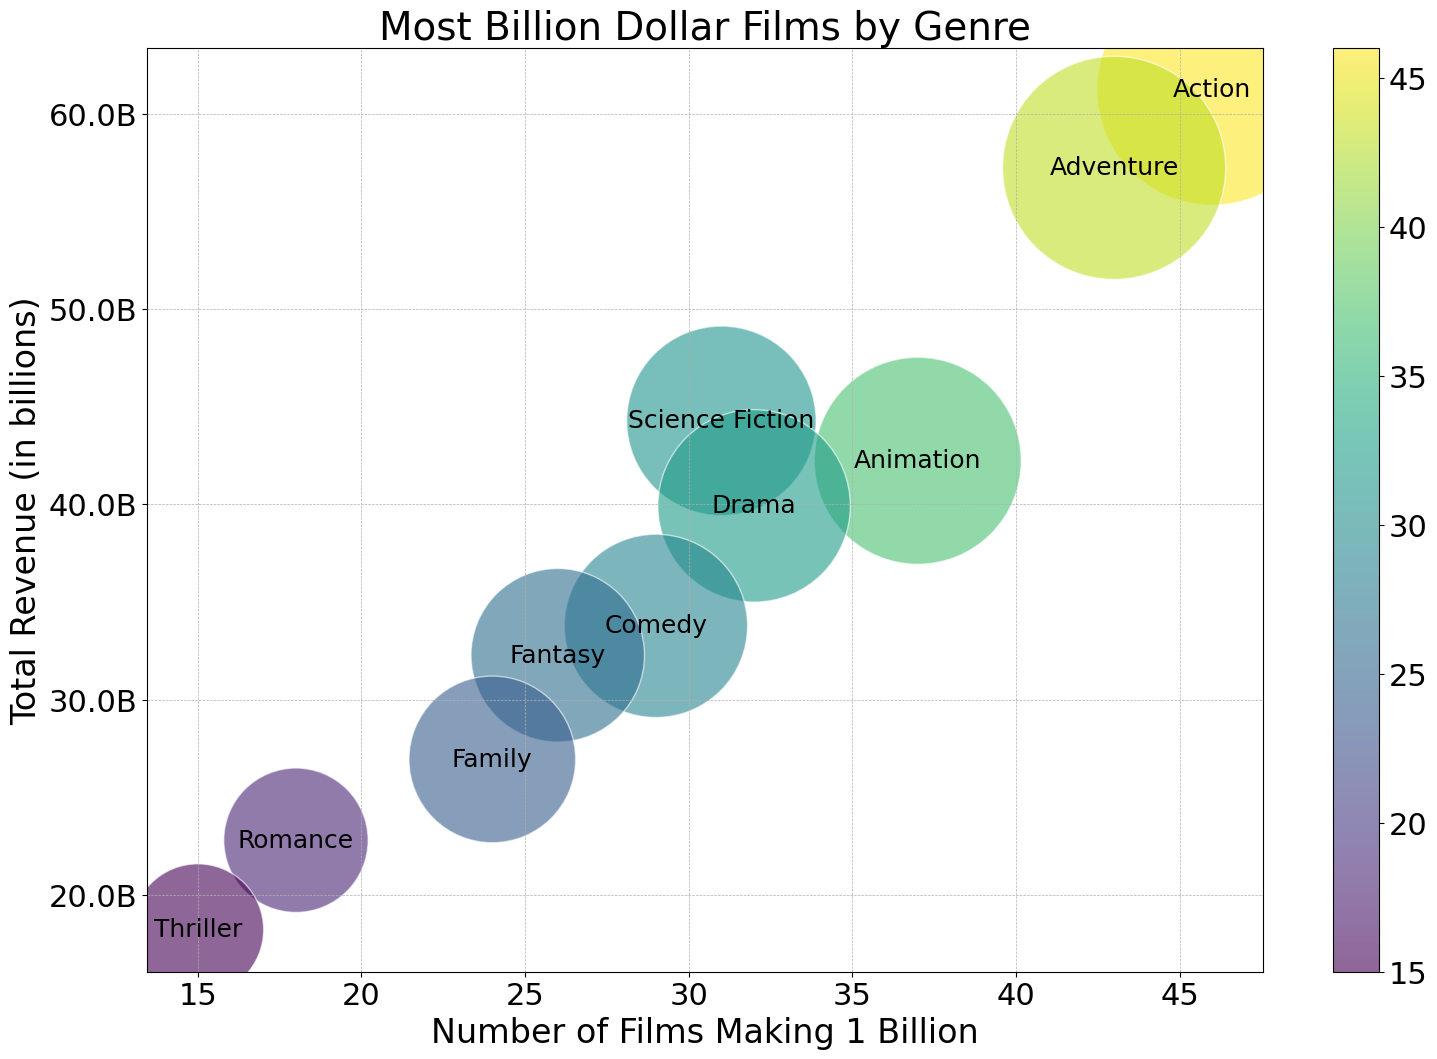

In [4]:
unique_movies['revenue'] = unique_movies['revenue'].fillna(0)
unique_movies['revenue'] = unique_movies['revenue'].astype(int)
unique_movies['gross'] = unique_movies['gross'].fillna(0).astype(int)

unique_movies.reset_index(drop=True, inplace=True)
unique_movies.loc[unique_movies['revenue'] == 0, 'revenue'] = unique_movies.loc[unique_movies['revenue'] == 0, 'gross']
unique_movies = unique_movies.drop('gross', axis = 1)

unique_movies['budget_x'] = unique_movies['budget_x'].fillna(0)
unique_movies['budget_x'] = unique_movies['budget_x'].astype(int)
unique_movies['budget'] = unique_movies['budget'].fillna(0).astype(int)

unique_movies.reset_index(drop=True, inplace=True)
unique_movies.loc[unique_movies['budget_x'] == 0, 'budget_x'] = unique_movies.loc[unique_movies['budget_x'] == 0, 'budget']
unique_movies = unique_movies.drop('budget', axis = 1)

unique_movies['date_x'] = pd.to_datetime(unique_movies['date_x'], errors='coerce')  # Coerce errors turn invalid parsing into NaT

# Step 2: Extract year from 'date_x'
unique_movies['year_from_date'] = unique_movies['date_x'].dt.year

# Step 3: Create 'release_year' by preferring 'year' but filling in from 'year_from_date'
unique_movies['release_year'] = unique_movies['year'].fillna(unique_movies['year_from_date']).astype(int)  # Convert to int, assuming no NaN remains

# Optional: Drop temporary columns if no longer needed
unique_movies.drop(['year', 'year_from_date'], axis=1, inplace=True)

# Rename 'date_x' to align with the new schema
unique_movies.rename(columns={'date_x': 'release_date'}, inplace=True)

unique_movies_exploded['date_x'] = pd.to_datetime(unique_movies_exploded['date_x'], errors='coerce')

# Extract the year from date_x
unique_movies_exploded['year_from_date_x'] = unique_movies_exploded['date_x'].dt.year

unique_movies_exploded['year_released'] = unique_movies_exploded['year_from_date_x'].fillna(unique_movies_exploded['year'])

# Convert year_released to integer, handling NaNs by converting them to a placeholder if necessary
unique_movies_exploded['year_released'] = unique_movies_exploded['year_released'].fillna(0).astype(int)

# Optionally, replace placeholder years with NaN if you prefer to keep them as missing values
unique_movies_exploded['year_released'].replace(0, pd.NA, inplace=True)



unique_movies_exploded.drop(columns=['year', 'year_from_date_x'], inplace=True)

genre_yearly_revenue = unique_movies_exploded.groupby(['genre', 'year_released'])['revenue'].sum().reset_index()

pivot_genre_revenue = genre_yearly_revenue.pivot(index='year_released', columns='genre', values='revenue').fillna(0)

filtered_data = unique_movies_exploded[unique_movies_exploded['genre'] != 'TV Movie']

average_revenue_by_genre = filtered_data.groupby('genre')['revenue'].sum().reset_index()

# Sort by average revenue and select top 10
top_10_genres_by_avg_revenue = average_revenue_by_genre.sort_values(by='revenue', ascending=False).head(10)

# Filter to get movies that grossed over $1 billion
billion_grossers = unique_movies_exploded[unique_movies_exploded['revenue'] > 1e9]

# Count the number of billion-grossing movies per genre
billion_count = billion_grossers.groupby('genre').size()

# Now integrate this count back to your top genres DataFrame
# Assuming 'top_10_genres_by_avg_revenue' already exists and has the correct genres
billion_grossers['billion_grossing_count'] = billion_grossers['genre'].map(billion_count)

# Fill missing values with 0 where no billion-grossing movies exist in the top genres
billion_grossers['billion_grossing_count'].fillna(0, inplace=True)

# Group by 'genre' and aggregate the total 'revenue' and count of films
genre_aggregates = billion_grossers.groupby('genre').agg(
    total_revenue=('revenue', 'sum'),
    billion_grossing_count=('name', 'count')  # Assuming 'name' uniquely identifies each film
).reset_index()

# Sort the DataFrame by 'total_revenue' in descending order
genre_aggregates = genre_aggregates.sort_values(by='total_revenue', ascending=False)

# Reset the index to make it a simple integer index
genre_aggregates.reset_index(drop=True, inplace=True)

# Select the top 10 genres by total revenue
top_10_genres = genre_aggregates.head(10)

top_10_genres.loc[:, 'total_revenue'] = top_10_genres['total_revenue'] / 1e9

# Creating the bubble chart
fig, ax1 = plt.subplots(figsize=(18, 12))
bubble_size = top_10_genres['billion_grossing_count']*600  # Adjust the size factor to ensure bubbles are visible and proportionate

scatter = ax1.scatter(
    top_10_genres['billion_grossing_count'],
    top_10_genres['total_revenue'],
    s=bubble_size,
    alpha=0.6,
    edgecolors='w',  # White edges for each bubble
    linewidth=1,     # Line width for bubble borders
    c=top_10_genres['billion_grossing_count'],  # Color by count of billion-grossing movies
    cmap='viridis'
)

# Adding labels and title
ax1.set_xlabel('Number of Films Making 1 Billion', fontsize=24)
ax1.set_ylabel('Total Revenue (in billions)', fontsize=24)
plt.title('Most Billion Dollar Films by Genre', fontsize=28)
ax1.grid(True, linestyle='--', linewidth=0.5)

# Adding annotations for each point centered in the bubbles
for i, txt in enumerate(top_10_genres['genre']):
    ax1.annotate(txt, (top_10_genres['billion_grossing_count'][i], top_10_genres['total_revenue'][i]), 
                 color='black', ha='center', va='center', fontsize=18)

# Setting the y-axis label format to show numbers as billions
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}B".format(x)))

# Adding a colorbar with larger font size
cbar = plt.colorbar(scatter, ax=ax1)
cbar.ax.tick_params(labelsize=22)  # Set font size for the color bar scale
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.show()